51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/5
100/100 [==============================] - 322s 3s/step - loss: 9.5591 - accuracy: 0.8334 - val_loss: 1.1707 - val_accuracy: 0.9162
Epoch 2/5
100/100 [==============================] - 306s 3s/step - loss: 1.5327 - accuracy: 0.8844 - val_loss: 3.1830 - val_accuracy: 0.7875
Epoch 3/5
100/100 [==============================] - 308s 3s/step - loss: 1.1752 - accuracy: 0.9091 - val_loss: 1.2347 - val_accuracy: 0.9112
Epoch 4/5
100/100 [==============================] - 307s 3s/step - loss: 0.7085 - accuracy: 0.9219 - val_loss: 0.6965 - val_accuracy: 0.9212
Epoch 5/5
100/100 [==============================] - 305s 3s/step - loss: 0.5558 - accuracy: 0.9325 - val_loss: 0.8336 - val_accuracy: 0.9125


25/25 [==============================] - 55s 2s/step - loss: 0.8336 - accuracy: 0.9125
Test Loss: 0.8336320519447327
Test Accuracy: 0.9125000238418579
25/25 [==============================] - 61s 2s/step
Confusion Matrix:
[[398  24]
 [ 46 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       422
           1       0.93      0.88      0.90       378

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



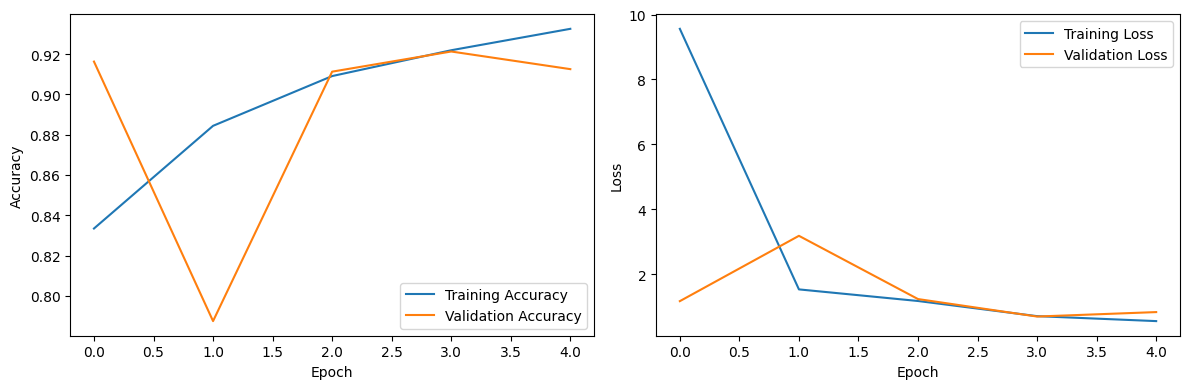

In [ ]:
import os
import cv2
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.densenet import DenseNet169
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Define the directory where your preprocessed images are stored
base_dir = '/content/drive/MyDrive/Skin cancer'

# Define the image size
image_size = (128, 128)

# Define the mapping between folder names and labels
label_mapping = {
    'benign': 0,
    'malignant': 1
}

# Create empty lists to store images and labels
images = []
labels = []

# Define the number of images to use for each class
num_images_per_class = 2000  # Set the desired number of images per class

# Iterate over disease folders
for folder, label in label_mapping.items():
    # Construct the full path of the disease folder
    folder_path = os.path.join(base_dir, folder)

    # Get the list of image files within the disease folder
    image_files = os.listdir(folder_path)

    # Shuffle the image files
    np.random.shuffle(image_files)

    # Iterate over image files
    for i, file_name in enumerate(image_files):
        # Check if the desired number of images per class is reached
        if i >= num_images_per_class:
            break

        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)

        # Load the image
        image = cv2.imread(file_path)

        # Resize the image
        resized_image = cv2.resize(image, image_size)

        # Append the resized image to the list of images
        images.append(resized_image)

        # Append the label to the list of labels
        labels.append(label)


# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels into integer values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Perform one-hot encoding on the labels
num_classes = len(label_mapping)
labels = to_categorical(labels, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Save the entire model as a SavedModel
model.save('model_saved')

# Save the label encoder classes
np.save('label_encoder_classes.npy', label_encoder.classes_)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions on the testing set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
